# Monitoring Image data using Fiddler Vector Monotoring

In this notebook we present the steps for monitoring images. Fiddler employs a vector-based monitoring approach that can be used to monitor data drift in high-dimensional data such as NLP embeddings, images, video etc. In this notebook we demonstrate how to detect drift in image data using model embeddings.

Fiddler is the pioneer in enterprise Model Performance Management (MPM), offering a unified platform that enables Data Science, MLOps, Risk, Compliance, Analytics, and LOB teams to **monitor, explain, analyze, and improve ML deployments at enterprise scale**. 
Obtain contextual insights at any stage of the ML lifecycle, improve predictions, increase transparency and fairness, and optimize business revenue.

---

You can experience Fiddler's Image monitoring ***in minutes*** by following these quick steps:

1. Connect to Fiddler
2. Load and generate embeddings for CIFAR-10 dataset
3. Upload the vectorized baseline dataset
4. Add metadata about your model 
5. Inject data drift and publish production events
6. Get insights

## Imports

In [ ]:
!pip install torch==2.0.0
!pip install torchvision==0.15.1
!pip install -q fiddler-client

In [ ]:
import numpy as np
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import torchvision
import requests

import fiddler as fdl
print(f"Running Fiddler client version {fdl.__version__}")

# 1. Connect to Fiddler

Before you can add information about your model with Fiddler, you'll need to connect using our API client.

---

**We need a few pieces of information to get started.**
1. The URL you're using to connect to Fiddler
2. Your organization ID
3. Your authorization token

The latter two of these can be found by pointing your browser to your Fiddler URL and navigating to the **Settings** page.

In [ ]:
URL = ''  # Make sure to include the full URL (including https://).
ORG_ID = ''
AUTH_TOKEN = ''

Now just run the following code block to connect to the Fiddler API!

In [ ]:
client = fdl.FiddlerApi(
    url=URL,
    org_id=ORG_ID,
    auth_token=AUTH_TOKEN,
)

Once you connect, you can create a new project by specifying a unique project ID in the client's `create_project` function.

In [ ]:
PROJECT_ID = 'image_monitoring'

if not PROJECT_ID in client.list_projects():
    print(f'Creating project: {PROJECT_ID}')
    client.create_project(PROJECT_ID)
else:
    print(f'Project: {PROJECT_ID} already exists')

## 2. Generate Embeddings for CIFAR-10 data

In this example, we'll use the popular CIFAR-10 classification dataset and a model based on Resnet-18 architecture. For the purpose of this example we have pre-trained the model. If you'd like to retrain the model you can use the script located here [TODO: Add link]
  
In order to compute data and prediction drift, **Fiddler needs a sample of data that can serve as a baseline** for making comparisons with data in production. When it comes to computing distributional shift for images, Fiddler relies on the model's intermediate representations also known as activations or embeddings. You can read more about our approach [here](https://www.fiddler.ai/blog/monitoring-natural-language-processing-and-computer-vision-models-part-1).

In the the following cells we'll extract these embeddings.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device to be used: {device}')

Let us load the pre-trained model

In [ ]:
MODEL_URL='https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/models/resnet18_cifar10_epoch5.pth'
MODEL_PATH='resnet18_cifar10_epoch5.pth'

def load_model(device):
    """Loads the pre-trained CIFAR-10 model"""
    model = resnet18()
    model.fc = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
    )
    
    r = requests.get(MODEL_URL)
    with open(MODEL_PATH,'wb') as f:
        f.write(r.content)
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))
    model.to(device)
    return model

resnet_model = load_model(device)

We'll need the CIFAR-10 dataloaders for this example. Note that running the cell below will download the CIFAR-10 data and load them using torch's dataloaders.

In [ ]:
image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
batch_size = 32
trainset = torchvision.datasets.CIFAR10(
    root='./cifar10_data',
    train=True,
    download=True,
    transform=image_transforms
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./cifar10_data',
    train=False,
    download=True,
    transform=image_transforms
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

***In the cell below we define functions that will extract the 128-dimensional embedding from the FC1 layer of the model***

In [ ]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

torch.manual_seed(0)

CIFAR_CLASSES = (
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog',
    'horse', 'ship', 'truck',
)

global view_fc1_output_embeds

def fc1_hook_func(model, input, output):
    global view_fc1_output_embeds
    view_fc1_output_embeds = output

def idx_to_classes(target_arr):
    return [CIFAR_CLASSES[int(i)] for i in target_arr]

def generate_embeddings(model, device, dataloader, n=100_000):
    """Generate embeddings for the inout images"""
    with torch.no_grad():
        model = model.eval()
        fc1_module = model.fc[0]
        fc1_hook = fc1_module.register_forward_hook(fc1_hook_func)
        correct_preds = 0
        images_processed = 0
        try:
            for i, (inputs, labels) in enumerate(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                outputs_smax = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels.data)
                if i == 0:
                    fc1_embeds = view_fc1_output_embeds.cpu().detach().numpy()
                    output_scores = outputs_smax.cpu().detach().numpy()
                    target = labels.cpu().detach().numpy()
                else:
                    fc1_embeds = np.concatenate((fc1_embeds, view_fc1_output_embeds.cpu().detach().numpy()))
                    output_scores = np.concatenate((output_scores, outputs_smax.cpu().detach().numpy()))
                    target = np.concatenate((target, labels.cpu().detach().numpy()))
                images_processed += outputs.size(0)
                if images_processed >= n:
                    break
        except Exception as e:
            fc1_hook.remove()
            raise
    
    embs = deepcopy(fc1_embeds[:n])
    labels = idx_to_classes(target[:n]) 
    embedding_cols = ['emb_'+str(i) for i in range(128)]
    baseline_embeddings = pd.DataFrame(embs, columns=embedding_cols)
    
    columns_to_combine = baseline_embeddings.columns  
    baseline_embeddings = baseline_embeddings.apply(lambda row: row[columns_to_combine].tolist(), axis=1).to_frame()
    baseline_embeddings = baseline_embeddings.rename(columns={baseline_embeddings.columns[0]: 'embeddings'})
    
    baseline_predictions = pd.DataFrame(output_scores[:n], columns=CIFAR_CLASSES)
    baseline_labels = pd.DataFrame(labels, columns=['target'])
    embeddings_df = pd.concat(
        [baseline_embeddings, baseline_predictions, baseline_labels],
        axis='columns',
        ignore_index=False
    )
    return embeddings_df


def get_cifar_transforms():
    image_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]
    )
    return image_transforms

def get_blur_transforms():
    image_transforms = transforms.Compose(
        [
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )
    return image_transforms

def get_brightness_transforms():
    image_transforms = transforms.Compose(
        [
            transforms.ColorJitter(brightness=(0.4, 0.6)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )
    return image_transforms

def get_cifar_dataloader(train_data=False, batch_size=32, shuffle_data=False, image_transforms=None):
    if image_transforms is None:
        image_transforms = get_cifar_transforms()
    dataset = torchvision.datasets.CIFAR10(root='./cifar10_data', train=train_data,
                                           download=True, transform=image_transforms)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle_data,
        num_workers=2
    )
    return dataloader

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

We'll now extract the embeddings for training data which will serve as baseline for monitoring.

In [ ]:
baseline_df = generate_embeddings(resnet_model, device, trainloader)

# Add a row number as a new column for each cifar10 image and a image_url as hosted by huggingface
baseline_df['image_number'] = baseline_df.reset_index().index
baseline_df['image_url'] = baseline_df.apply(
    lambda row: f"https://datasets-server.huggingface.co/assets/cifar10/--/plain_text/train/{row['image_number']}/img/image.jpg", 
    axis=1
)
baseline_df.head(5)

# 3. Upload the vectorized baseline dataset to Fiddler

Next, let's create a [DatasetInfo](https://docs.fiddler.ai/reference/fdldatasetinfo) object to describe our baseline dataset and then [upload_dataset()](https://docs.fiddler.ai/reference/clientupload_dataset) to Fiddler.

In [ ]:
DATASET_ID = 'cifar10_baseline'  # The dataset name in Fiddler platform
dataset_info = fdl.DatasetInfo.from_dataframe(baseline_df, max_inferred_cardinality=100)

if not DATASET_ID in client.list_datasets(project_id=PROJECT_ID):
    print(f'Uploading dataset {DATASET_ID}')
    
    client.upload_dataset(
        project_id=PROJECT_ID,
        dataset_id=DATASET_ID,
        dataset={'baseline': baseline_df},
        info=dataset_info
    )
    print('Finished uploading the baseline dataset.')
else:
    print(f'Dataset: {DATASET_ID} already exists in Project: {PROJECT_ID}.\n'
               'The new dataset is not uploaded. (please use a different name.)')

# 4. Add metadata about the model

Next we must tell Fiddler a bit more about our model.  This is done either by calling [.register_model()](https://docs.fiddler.ai/reference/clientregister_model) or [.add_model()](https://docs.fiddler.ai/reference/clientadd_model).  This notebook will use [.add_model()](https://docs.fiddler.ai/reference/clientadd_model) When calling [.add_model()](https://docs.fiddler.ai/reference/clientadd_model), we must pass in a [model_info](https://docs.fiddler.ai/reference/fdlmodelinfo) object to tell Fiddler about our model.  This [model_info](https://docs.fiddler.ai/reference/fdlmodelinfo) object will tell Fiddler about our model's task, inputs, output, target and which features form the image embedding.

Let's first define our Image vector using the API below.

In [ ]:
image_embedding_feature = fdl.ImageEmbedding(
    name='image_feature',
    source_column='image_url',
    column='embeddings',
)

Now let's define our [model_info](https://docs.fiddler.ai/reference/fdlmodelinfo) object.

In [ ]:
# This is a multi-class classification problem
model_task = fdl.ModelTask.MULTICLASS_CLASSIFICATION
# name of the column that contains ground truth
features = ['embeddings']
metadata = ['image_url']
target = 'target'

model_info = fdl.ModelInfo.from_dataset_info(
    dataset_info=dataset_info,
    dataset_id=DATASET_ID,
    features=features,
    target=target,
    outputs=CIFAR_CLASSES,
    custom_features=[image_embedding_feature],
    model_task=model_task,
    metadata_cols=metadata,
    description='An example to showcase monitoring Image data using model embeddings.',
    categorical_target_class_details=list(CIFAR_CLASSES),
)
model_info

Now we specify a unique model ID and use the client's [add_model](https://docs.fiddler.ai/reference/clientadd_model) function to send this information to Fiddler.

In [ ]:
MODEL_ID = 'resnet18'

client.add_model(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    model_id=MODEL_ID,
    model_info=model_info,
)

# 5. Inject data drift and publish production events

Netx, we'll inject data drift in form of blurring and brightness-reduction. The following cell illustrates these transforms.

In [ ]:
drift_xform_lut = {
    'original': None,
    'blurred': get_blur_transforms(),
    'brightness_reduced': get_brightness_transforms(),
}
for drift_type, xform in drift_xform_lut.items():
    cifar_testloader = get_cifar_dataloader(train_data=False, batch_size=32, image_transforms=xform)
    # get some test images
    dataiter = iter(cifar_testloader)
    images, labels = next(dataiter)

    # show images
    print(f'Image type: {drift_type}')
    imshow(torchvision.utils.make_grid(images))

### Publish events to Fiddler

We'll publish events over past 3 weeks. 

- Week 1: We publish CIFAR-10 test set, which would signify no distributional shift
- Week 2: We publish **blurred** CIFAR-10 test set 
- Week 3: We publish **brightness reduce** CIFAR-10 test set 

In [ ]:
import time

for i, drift_type in enumerate(['original', 'blurred', 'brightness_reduced']):
    week_days = 6
    xform = drift_xform_lut[drift_type]
    cifar_testloader = get_cifar_dataloader(train_data=False, batch_size=32, image_transforms=xform)
    prod_df = generate_embeddings(resnet_model, device, cifar_testloader)
    week_offset = (2-i)*7*24*60*60*1e3 
    day_offset = 24*60*60*1e3
    print(f'Publishing events with {drift_type} transformation for week {i}.')
    for day in range(week_days): 
        now = time.time() * 1000
        timestamp = int(now - week_offset - day*day_offset)
        events_df = prod_df.sample(1000)
        events_df['timestamp'] = timestamp
        client.publish_events_batch(
            project_id=PROJECT_ID,
            model_id=MODEL_ID,
            batch_source=events_df,
            timestamp_field='timestamp',
        )

## 6. Get insights

**You're all done!**
  
You can now head to Fiddler URL and start getting enhanced observability into your model's performance.

Fiddler can now track your image drift over time based on the embedding vectors of the images published into the platform.  Please visit your Fiddler environment upon completion to check this out for yourself.

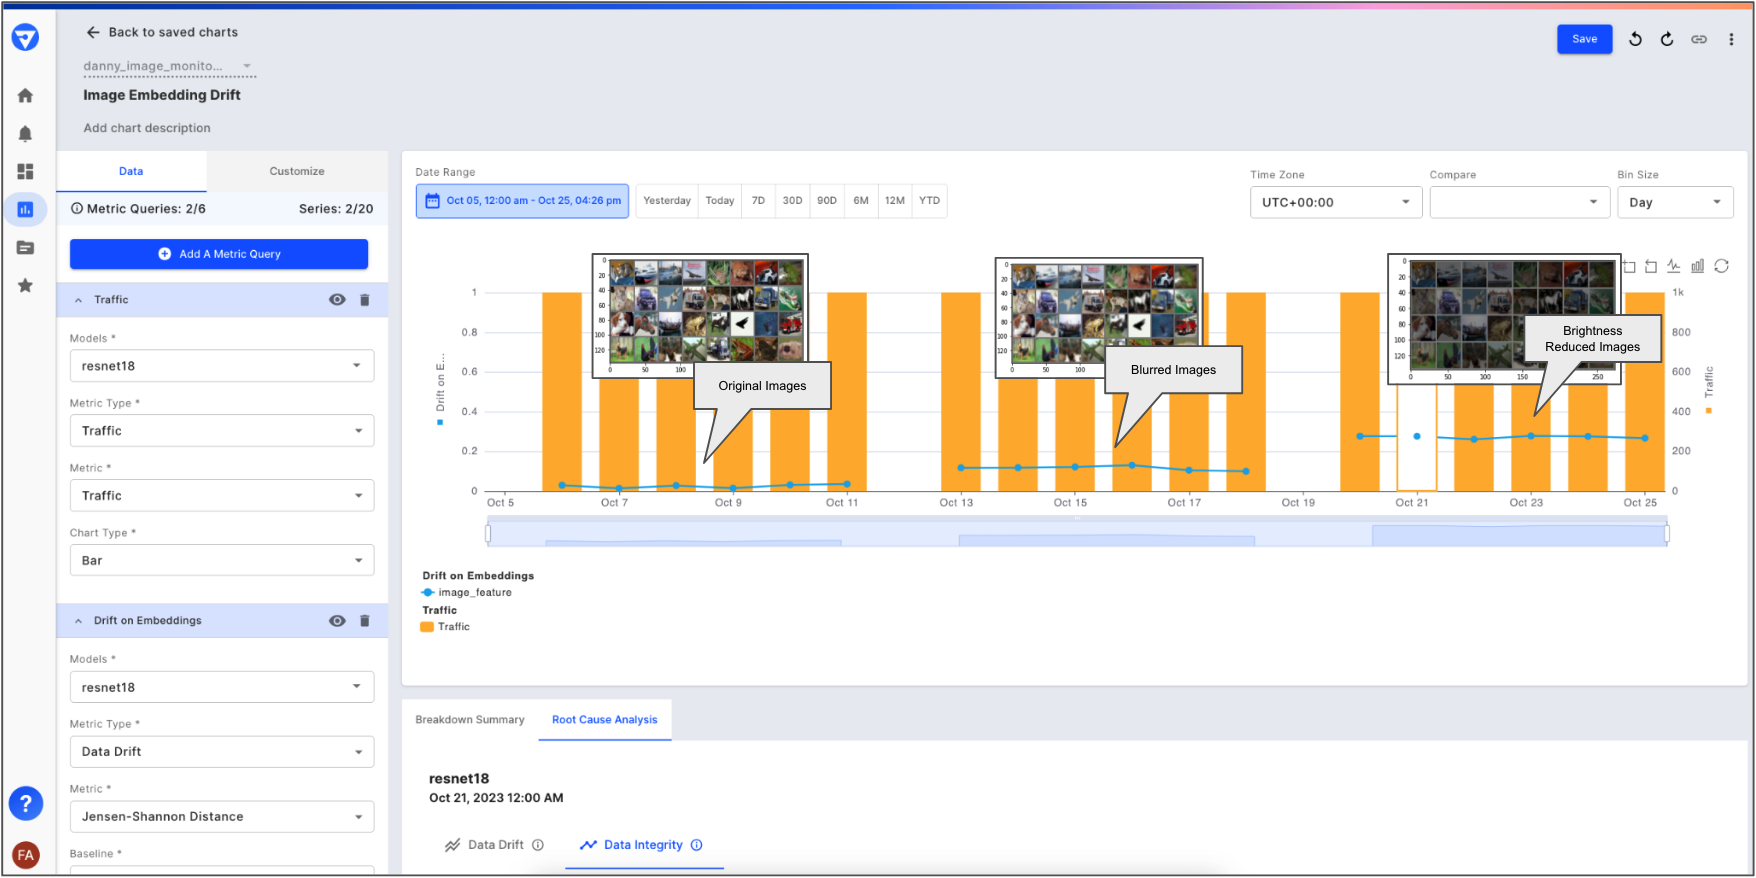



---


**Questions?**  
  
Check out [our docs](https://docs.fiddler.ai/) for a more detailed explanation of what Fiddler has to offer.

Join our [community Slack](http://fiddler-community.slack.com/) to ask any questions!

If you're still looking for answers, fill out a ticket on [our support page](https://fiddlerlabs.zendesk.com/) and we'll get back to you shortly.